# Data-Original: Preprocessing, Classification, and Collaboration Success Plots

This notebook processes Excel files in `data-original/` and performs:

0. Combine all `Experiment Data` sheets into one CSV; remove trials in 2P2G and 2P3G where `player1Trajectory` or `player2Trajectory` is empty.
1. Classify each Excel by unique values of `partnerAgentType` within 2P2G/2P3G into game types: `human`, `gpt-4.1-mini`, or `mixed`. For `mixed`, compute percent of human trials.
2. Plot trial-level `collaborationSucceeded` for 2P2G and 2P3G by `partnerAgentType`.
3. Plot participant-level collaboration success by the new game type (from step 1).

Notes:
- Expected sheet name variants for experiment data: `Experiment Data`, `experiment data`, `ExperimentData`, `Data`.
- Column variants are handled where possible (e.g., `collaborationSucceeded`, `success`).
- Figures are saved to this folder. Combined CSVs are saved alongside.

In [10]:
# Imports & plotting style
from pathlib import Path
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 180)
sns.set(style='whitegrid')

BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'data-original'
EXCEL_GLOB = 'experiment_data_*.xlsx'

COMBINED_CSV = BASE_DIR / 'combined_experiment_data_original.csv'
CLASSIFICATION_CSV = BASE_DIR / 'game_type_classification_original.csv'
PARTICIPANT_SUMMARY_CSV = BASE_DIR / 'participant_success_summary_original.csv'

list(DATA_DIR.glob(EXCEL_GLOB))[:3]

[PosixPath('data-original/experiment_data_5a5bd24be0cf3d000126849e_room_9922acb2-7db1-47ea-b369-ff389b4e47a5_2025-09-13T18-17-31-453Z.xlsx'),
 PosixPath('data-original/experiment_data_652c5f38cf13042034313b91_room_b2209a3e-c750-4a3e-a4a4-093f62e7ef08_2025-09-13T18-19-19-226Z.xlsx'),
 PosixPath('data-original/experiment_data_5b985404a15058000124e508_room_fa684eb1-e4c4-4905-96b7-15cf7b8a3f2d_2025-09-12T16-55-36-623Z.xlsx')]

In [11]:
# Helper functions
def file_id_from_path(p: Path) -> str:
    return p.name

def find_experiment_sheet(xls) -> str | None:
    for candidate in ['Experiment Data', 'experiment data', 'ExperimentData', 'Data']:
        if candidate in xls.sheet_names:
            return candidate
    return None

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    # trialIndex
    if 'trialIndex' not in df.columns:
        for alt in ['trial_index', 'trial', 'trialId', 'trialID']:
            if alt in df.columns:
                df = df.rename(columns={alt: 'trialIndex'})
                break
    # experimentType
    if 'experimentType' not in df.columns:
        for alt in ['experiment_type', 'experiment', 'ExperimentType']:
            if alt in df.columns:
                df = df.rename(columns={alt: 'experimentType'})
                break
    # collaborationSucceeded
    if 'collaborationSucceeded' not in df.columns:
        for alt in ['collaboration_success', 'success', 'collabSuccess']:
            if alt in df.columns:
                df = df.rename(columns={alt: 'collaborationSucceeded'})
                break
    # partnerAgentType
    if 'partnerAgentType' not in df.columns:
        for alt in ['partner_type', 'partnerAgent', 'partner', 'partnerType']:
            if alt in df.columns:
                df = df.rename(columns={alt: 'partnerAgentType'})
                break
    # participant/room ids if present (used for grouping later)
    if 'participantID' not in df.columns:
        for alt in ['participantId', 'participant', 'subject', 'playerId']:
            if alt in df.columns:
                df = df.rename(columns={alt: 'participantID'})
                break
    if 'roomId' not in df.columns:
        for alt in ['room_id', 'room', 'sessionId', 'roomID']:
            if alt in df.columns:
                df = df.rename(columns={alt: 'roomId'})
                break
    return df

def to_bool01(s: pd.Series) -> pd.Series:
    # Convert booleans / truthy strings to {0,1} numeric for averaging
    if s.dtype == bool:
        return s.astype(int)
    return s.replace({
        'true': 1, 'false': 0, 'True': 1, 'False': 0, True: 1, False: 0
    }).astype('float', errors='ignore')

def is_empty_list_value(val) -> bool:
    if val is None:
        return True
    # direct lists
    if isinstance(val, (list, tuple)):
        return len(val) == 0
    # strings
    s = str(val).strip()
    if s == '' or s == '[]' or s.lower() in ('none', 'nan'):
        return True
    # try json parse
    try:
        parsed = json.loads(s)
        if isinstance(parsed, (list, tuple)):
            return len(parsed) == 0
    except Exception:
        pass
    return False

def load_experiment_data_one_file(p: Path) -> pd.DataFrame:
    import pandas as pd
    try:
        xls = pd.ExcelFile(p)
    except Exception as e:
        print(f'[WARN] Failed to open {p.name}: {e}')
        return pd.DataFrame()
    sheet = find_experiment_sheet(xls)
    if sheet is None:
        print(f'[INFO] No Experiment Data sheet in {p.name}. Found: {xls.sheet_names}')
        return pd.DataFrame()
    try:
        df = pd.read_excel(p, sheet_name=sheet)
    except Exception as e:
        print(f'[WARN] Failed to read {sheet} from {p.name}: {e}')
        return pd.DataFrame()
    df = normalize_columns(df)
    # Drop duplicate trials within file if trialIndex present
    if 'trialIndex' in df.columns:
        df = df.drop_duplicates(subset=['trialIndex'], keep='last')
    # Attach file metadata
    df['source_file'] = p.name
    df['file_id'] = file_id_from_path(p)
    return df


In [12]:
# Load and combine Experiment Data across all Excel files
excel_paths = sorted([p for p in DATA_DIR.glob(EXCEL_GLOB) if not p.name.startswith('~$')])
print(f'Found {len(excel_paths)} Excel files in {DATA_DIR}')

frames = []
for p in excel_paths:
    df = load_experiment_data_one_file(p)
    if not df.empty:
        frames.append(df)

combined = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
print(f'Combined rows before cleaning: {len(combined)}')

# Ensure collaborationSucceeded numeric for later stats
if 'collaborationSucceeded' in combined.columns:
    combined['collaborationSucceeded'] = to_bool01(combined['collaborationSucceeded'])

# Step 0: Remove trials in 2P2G/2P3G with empty trajectories
if not combined.empty:
    mask_target = combined['experimentType'].isin(['2P2G', '2P3G']) if 'experimentType' in combined.columns else pd.Series(False, index=combined.index)
    if 'player1Trajectory' in combined.columns and 'player2Trajectory' in combined.columns:
        empty1 = combined['player1Trajectory'].apply(is_empty_list_value)
        empty2 = combined['player2Trajectory'].apply(is_empty_list_value)
        to_drop = mask_target & (empty1 | empty2)
        dropped = int(to_drop.sum())
        combined_clean = combined.loc[~to_drop].copy()
        print(f'Dropped {dropped} empty-trajectory rows in 2P2G/2P3G; remaining: {len(combined_clean)}')
    else:
        print('Trajectory columns not found; no drops applied for empty trajectories.')
        combined_clean = combined.copy()
else:
    combined_clean = combined.copy()

# Save combined CSV
combined_clean.to_csv(COMBINED_CSV, index=False)
COMBINED_CSV

Found 50 Excel files in data-original
Combined rows before cleaning: 600
Dropped 5 empty-trajectory rows in 2P2G/2P3G; remaining: 595


PosixPath('combined_experiment_data_original.csv')

In [13]:
# Step 1: Classify each Excel by partnerAgentType within 2P2G/2P3G
if combined_clean.empty or 'partnerAgentType' not in combined_clean.columns:
    print('No data or missing partnerAgentType; classification skipped.')
    classification = pd.DataFrame()
else:
    data_2p = combined_clean[combined_clean['experimentType'].isin(['2P2G','2P3G'])].copy()
    # normalize partnerAgentType values
    data_2p['partnerAgentType'] = data_2p['partnerAgentType'].astype(str).str.strip()
    # Group by source_file (each Excel)
    rows = []
    for file_name, df_file in data_2p.groupby('source_file'):
        partner_vals = sorted(df_file['partnerAgentType'].dropna().unique().tolist())
        # core types we care about
        types_lower = {v.lower() for v in partner_vals}
        has_human = ('human' in types_lower)
        has_gpt41 = any('gpt-4.1-mini' in v for v in partner_vals) or ('gpt-4.1-mini' in types_lower)
        if has_human and not has_gpt41 and len(types_lower) == 1:
            game_type = 'human'
        elif has_gpt41 and not has_human and len(types_lower) == 1:
            game_type = 'gpt-4.1-mini'
        else:
            game_type = 'mixed'
        # percent human trials in 2P* for mixed
        n_total = len(df_file)
        n_human = int((df_file['partnerAgentType'].str.lower() == 'human').sum())
        human_pct = (n_human / n_total) if n_total > 0 else np.nan
        room_id = df_file['roomId'].mode(dropna=True).iloc[0] if 'roomId' in df_file.columns and not df_file['roomId'].dropna().empty else np.nan
        rows.append({
            'source_file': file_name,
            'roomId': room_id,
            'unique_partner_types': ','.join(partner_vals),
            'game_type': game_type,
            'human_trial_percent': round(human_pct, 4)
        })
    classification = pd.DataFrame(rows)
    classification = classification.sort_values(by=['game_type','source_file']).reset_index(drop=True)

classification.to_csv(CLASSIFICATION_CSV, index=False)
classification.head(10)

,source_file,roomId,unique_partner_types,game_type,human_trial_percent
0,experiment_data_572f526c3c27e7000e0b8aaa_room_...,752d4cef-6dc3-4d68-9d9d-0815e9d70bae,gpt-4.1-mini,gpt-4.1-mini,0.0
1,experiment_data_57dd3b0e91b7fc0001493db9_room_...,b5ed8553-19fc-43a4-ae35-6e256c500817,gpt-4.1-mini,gpt-4.1-mini,0.0
2,experiment_data_596de39c9fd5ee0001b704c3_room_...,b2209a3e-c750-4a3e-a4a4-093f62e7ef08,gpt-4.1-mini,gpt-4.1-mini,0.0
3,experiment_data_5aff33bae55f90000139f664_room_...,61690307-cecf-4eb5-bed9-b1c691b7b9a2,gpt-4.1-mini,gpt-4.1-mini,0.0
4,experiment_data_5c0558b8553fb80001191980_room_...,aa6f51e0-a8a1-49f7-ba8a-a3f3bba2b5f5,gpt-4.1-mini,gpt-4.1-mini,0.0
5,experiment_data_5dc3552003f8562725a1b956_room_...,e55b3b94-4195-40a0-b088-223a8c4f1d88,gpt-4.1-mini,gpt-4.1-mini,0.0
6,experiment_data_5e1b795dc799223a3b447ada_room_...,61690307-cecf-4eb5-bed9-b1c691b7b9a2,gpt-4.1-mini,gpt-4.1-mini,0.0
7,experiment_data_5f850c99d40bfe1f29078e69_room_...,49124e6f-79b4-4627-ab53-ba0f80c28c33,gpt-4.1-mini,gpt-4.1-mini,0.0
8,experiment_data_652c5f38cf13042034313b91_room_...,b2209a3e-c750-4a3e-a4a4-093f62e7ef08,gpt-4.1-mini,gpt-4.1-mini,0.0
9,experiment_data_660453c9877e571d12b555f7_room_...,33225ba8-f6fe-4cf4-91ee-5530c0096612,gpt-4.1-mini,gpt-4.1-mini,0.0


,experimentType,partnerAgentType,mean,std,count,se
0,2P2G,gpt-4.1-mini,0.333333,0.577350,3,0.333333
1,2P3G,gpt-4.1-mini,0.783251,0.413049,203,0.028990
2,2P3G,human,0.938144,0.241204,388,0.012245


/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_12727/2367441529.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sub, x='partnerAgentType', y='mean', palette='pastel')


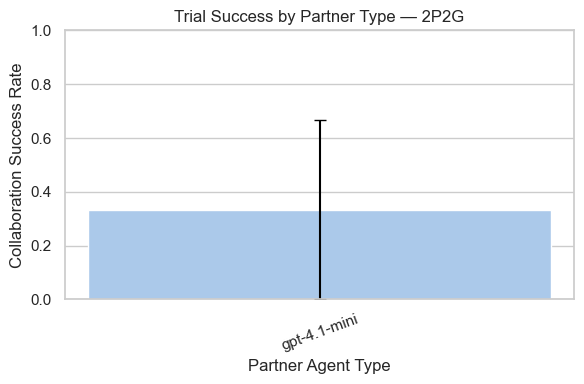

Saved: trial_success_by_partner_type_2P2G.png


/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_12727/2367441529.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sub, x='partnerAgentType', y='mean', palette='pastel')


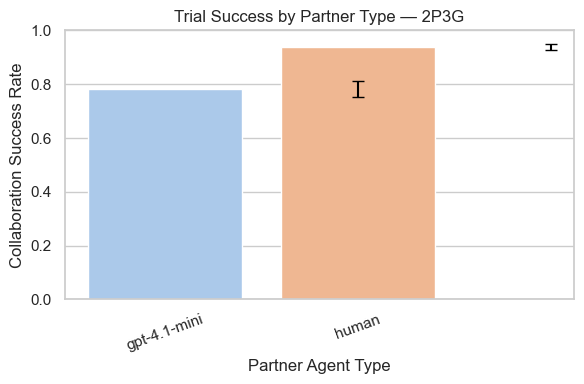

Saved: trial_success_by_partner_type_2P3G.png


In [14]:
# Step 2: Trial-level collaborationSucceeded for 2P2G and 2P3G by partnerAgentType
if combined_clean.empty or 'partnerAgentType' not in combined_clean.columns or 'experimentType' not in combined_clean.columns:
    print('Missing data/columns for trial-level plot.')
else:
    plot_df = combined_clean[combined_clean['experimentType'].isin(['2P2G','2P3G'])].copy()
    plot_df['partnerAgentType'] = plot_df['partnerAgentType'].astype(str).str.strip()
    # Aggregate success rate per partner type and experiment type
    agg = (plot_df
           .groupby(['experimentType','partnerAgentType'])['collaborationSucceeded']
           .agg(['mean','std','count'])
           .reset_index())
    agg['se'] = agg['std'] / np.sqrt(agg['count'].clip(lower=1))
    display(agg.head(10))

    # Plot bars for each experiment type
    exp_types = ['2P2G','2P3G']
    for et in exp_types:
        sub = agg[agg['experimentType'] == et]
        plt.figure(figsize=(6,4))
        ax = sns.barplot(data=sub, x='partnerAgentType', y='mean', palette='pastel')
        # error bars (SE)
        for i, row in sub.iterrows():
            ax.errorbar(i, row['mean'], yerr=row['se'], fmt='none', ecolor='black', capsize=4)
        ax.set_ylim(0,1)
        ax.set_title(f'Trial Success by Partner Type — {et}')
        ax.set_ylabel('Collaboration Success Rate')
        ax.set_xlabel('Partner Agent Type')
        plt.xticks(rotation=20)
        out = BASE_DIR / f'trial_success_by_partner_type_{et}.png'
        plt.tight_layout()
        plt.savefig(out, dpi=200)
        plt.show()
        print('Saved:', out)


,participantKey,game_type,success_rate
0,1aa4a978-1316-4242-a21e-9772545006a7,human,1.000000
1,3058f602-8cd4-402d-96ff-5aa79525a18e,human,0.916667
2,329a09b2-ad1f-4458-af0b-f7dd194297d1,human,0.958333
3,33225ba8-f6fe-4cf4-91ee-5530c0096612,gpt-4.1-mini,0.833333
4,3f333c71-69b9-47d2-afa2-a8cdd8a7a34f,gpt-4.1-mini,1.000000
5,49124e6f-79b4-4627-ab53-ba0f80c28c33,gpt-4.1-mini,0.666667
6,49124e6f-79b4-4627-ab53-ba0f80c28c33,mixed,0.750000
7,5de6a11a-219d-4804-b614-ef42656f3066,human,0.833333
8,5de6a11a-219d-4804-b614-ef42656f3066,mixed,0.833333
9,61690307-cecf-4eb5-bed9-b1c691b7b9a2,gpt-4.1-mini,0.875000


/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_12727/1547794383.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=part, x='game_type', y='success_rate', palette='pastel')


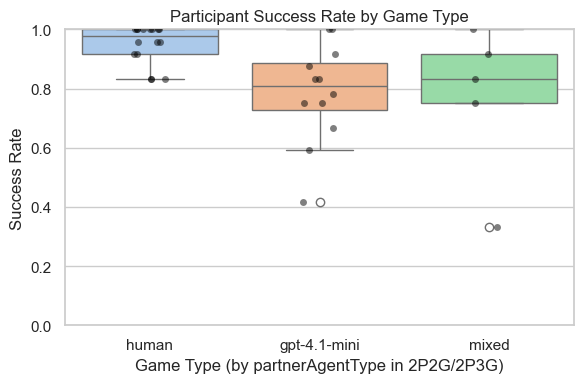

Saved: participant_success_by_game_type.png


In [15]:
# Step 3: Participant-level collaboration success by game type (from Step 1)
# Define participant as roomId if present; else source_file.
if combined_clean.empty:
    print('No combined data available.')
else:
    dfp = combined_clean.copy()
    dfp['participantKey'] = (dfp['roomId'] if 'roomId' in dfp.columns else dfp['source_file'])
    # Limit to 2P2G/2P3G to align with classification basis
    dfp = dfp[dfp['experimentType'].isin(['2P2G','2P3G'])] if 'experimentType' in dfp.columns else dfp
    # Attach game type classification
    if not classification.empty:
        key = 'source_file'
        dfp = dfp.merge(classification[[key,'game_type']], how='left', left_on='source_file', right_on=key, suffixes=('','')).drop(columns=[key])
    else:
        dfp['game_type'] = np.nan

    # Compute participant-level success rate
    part = (dfp.groupby(['participantKey','game_type'])['collaborationSucceeded']
              .mean().reset_index(name='success_rate'))
    part.to_csv(PARTICIPANT_SUMMARY_CSV, index=False)
    display(part.head(10))

    # Plot participant-level success by game_type
    plt.figure(figsize=(6,4))
    ax = sns.boxplot(data=part, x='game_type', y='success_rate', palette='pastel')
    sns.stripplot(data=part, x='game_type', y='success_rate', color='black', alpha=0.5)
    ax.set_ylim(0,1)
    ax.set_title('Participant Success Rate by Game Type')
    ax.set_xlabel('Game Type (by partnerAgentType in 2P2G/2P3G)')
    ax.set_ylabel('Success Rate')
    outp = BASE_DIR / 'participant_success_by_game_type.png'
    plt.tight_layout()
    plt.savefig(outp, dpi=200)
    plt.show()
    print('Saved:', outp)
